In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# AWS regions
names = [
    "us-east-1",      # US East (N. Virginia)
    "us-west-1",      # US West (N. California)
    "us-west-2",      # US West (Oregon)
    "af-south-1",     # Africa (Cape Town)
    "ap-south-2",     # Asia Pacific (Hyderabad)
    "ap-northeast-2", # Asia Pacific (Seoul)
    "ap-southeast-2", # Asia Pacific (Sydney)
    "ca-central-1",   # Canada (Central)
    "eu-central-1",   # Europe (Frankfurt)
    "eu-west-2",      # Europe (London)
    "eu-west-3",      # Europe (Paris)
    "eu-north-1",     # Europe (Stockholm)
    "sa-east-1",       # South America (São Paulo)
    "il-central-1"    # Israel (Tel Aviv)
]

# load latency measurements from csv
df = pd.read_csv("latencies.csv", index_col=0)
df.head()

,from,to,latency
datetime,,,
2024-07-03 20:00:41,eu-west-2,us-east-1,398
2024-07-03 20:00:47,eu-west-2,us-west-1,561
2024-07-03 20:00:50,eu-west-2,us-west-2,457
2024-07-03 20:00:54,eu-west-2,af-south-1,585
2024-07-03 20:00:58,eu-west-2,ap-south-2,555


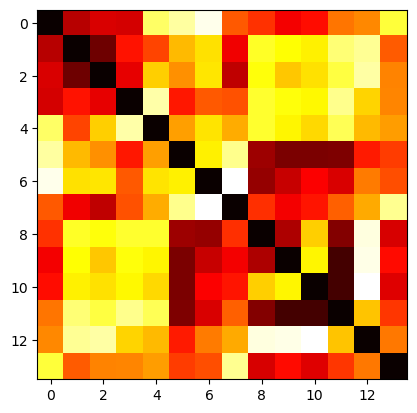

In [3]:
# compute average and std dev of latencies between the AWS regions and store them in a matrix
avg_distances = np.zeros((len(names), len(names)))
std_dev_distances = np.zeros((len(names), len(names)))
                     
for from_region in names:
    for to_region in names:
        if from_region == to_region:
            continue
        # filter the dataframe to get the latencies between the two regions
        latencies_from = df[(df['from'] == from_region) & (df['to'] == to_region)]['latency']
        latencies_to = df[(df['from'] == to_region) & (df['to'] == from_region)]['latency']
        # combine the two series
        latencies = pd.concat([latencies_from, latencies_to])
        # compute the average and std dev
        avg_distances[names.index(from_region), names.index(to_region)] = latencies.mean()
        avg_distances[names.index(to_region), names.index(from_region)] = latencies.mean()
        std_dev_distances[names.index(from_region), names.index(to_region)] = latencies.std()
        std_dev_distances[names.index(to_region), names.index(from_region)] = latencies.std()

# plot the distance matrix
plt.imshow(avg_distances, cmap='hot', interpolation='nearest')


In [4]:
# use the FRT algorithm to embed a metric space into a hierarchically separated tree


In [42]:
import random
import math
from collections import defaultdict

class Node:
    def __init__(self, point):
        self.point = point
        self.children = []

class Tree:
    def __init__(self, root):
        self.root = root

def distance(point1, point2):
    return avg_distances[names.index(point1), names.index(point2)]

def random_partition(points, radius):
    """
    Randomly partition the points based on a given radius.
    """
    clusters = defaultdict(list)
    # Select a random center
    center = random.choice(points)
    for point in points:
        d = distance(center, point)
        if d < radius:
            clusters[center].append(point)
    return clusters

def build_tree(points, radius):
    if not points:
        return None

    partitions = random_partition(points, radius)
    root = Node(None)
    for center, cluster in partitions.items():
        if cluster:
            child = build_tree(cluster, radius / 2)
            root.children.append(child)
    return root

def ball(points, point, radius):
    """
    Return the set of points within the ball of the given radius centered at the given point.
    """
    point_set = set()
    for p in points:
        d = distance(point, p)
        if d <= radius:
            point_set.add(p)
    return point_set

def diameter(points):
    return max(distance(p1, p2) for p1 in points for p2 in points)

def frt_algorithm(points):
    diam = diameter(points)
    n = len(points)
    log_delta = np.ceil(np.log2(diam))

    # permute the points and save them in pi
    pi = np.random.permutation(points)

    # choose r_0
    radius_0 = np.random.uniform(0.5, 1)
    radius_0 = 1
    radii = [radius_0 * 2**i for i in range(1, int(log_delta) + 1)]

    # set of nodes at each level (dict)
    levels = defaultdict(list)
    ancestors = defaultdict(list)
    edgeweights = defaultdict(float)
    levels[log_delta] = [frozenset(points)]
    ancestors[log_delta] = None
    end = 1

    for i in reversed(range(1, int(log_delta)+1)):
        # get the sets of nodes at level i
        Cs = levels[i]
        # if the length of Cs is n, we are done
        if len(Cs) == n:
            end = i
            break
        # print("i: {}, Cs: {}".format(i,Cs))
        for C in Cs:
            # print("i: {}, C: {}".format(i,C))
            S = C.copy()
            for j in range(0, n):
                B = ball(points, pi[j], radii[i-1])
                # print("i: {}, C: {}, radius: {}, B: {}".format(i, C, radii[i-1], B))
                P = S.intersection(B)
                # if P is not empty...
                if len(P) > 0:
                    S = S.difference(P)
                    # add P to T as a child of C at level i-1
                    levels[i-1].append(frozenset(P))
                    ancestors[i-1].append(frozenset(C))
        edgeweights[i-1] = radii[i-1]

    # build the tree
    root = Node(frozenset(points))
    tree = Tree(root)
    cur_level = [root]
    completed = set()
    for i in reversed(range(end, int(log_delta))):
        next_level = []
        for C, parent in zip(levels[i], ancestors[i]):
            # get parent node from current level
            parent_node = None
            for node in cur_level:
                if node.point == parent:
                    parent_node = node
                    break
            # check if the parent and C are identical with length 1
            if parent == C and len(C) == 1:
                continue
            # create a new node
            new_node = Node(C)
            parent_node.children.append(new_node)
            next_level.append(new_node)
            # if C has length one, add it to the completed set and add an OFF state
            if len(C) == 1:
                completed.add(C)
                leaf_node = Node("OFF")
                new_node.children.append(leaf_node)
        cur_level = next_level
    
    return tree, edgeweights, log_delta
    

# Example usage:
points = names
# levels, ancestors = frt_algorithm(points)
tree, weights, levels = frt_algorithm(points)

def print_tree(node, level=0):
    if node:
        print(' ' * level * 10, str(list(node.point)))
        for child in node.children:
            print_tree(child, level + 1)

print_tree(tree.root)
# print(tree.root.children)

 ['ap-northeast-2', 'ap-south-2', 'sa-east-1', 'eu-west-2', 'us-west-2', 'us-east-1', 'ap-southeast-2', 'af-south-1', 'eu-north-1', 'eu-west-3', 'il-central-1', 'ca-central-1', 'us-west-1', 'eu-central-1']
           ['ca-central-1', 'ap-northeast-2', 'ap-south-2', 'sa-east-1', 'eu-west-2', 'us-west-2', 'us-east-1', 'ap-southeast-2', 'af-south-1', 'eu-north-1', 'il-central-1', 'eu-west-3', 'us-west-1', 'eu-central-1']
                     ['ap-northeast-2', 'sa-east-1', 'us-east-1', 'ap-southeast-2', 'il-central-1']
                               ['sa-east-1']
                                         ['O', 'F', 'F']
                               ['il-central-1']
                                         ['O', 'F', 'F']
                               ['ap-northeast-2']
                                         ['O', 'F', 'F']
                               ['ap-southeast-2']
                                         ['O', 'F', 'F']
                               ['us-east-1']
            

In [39]:
print(weights)

defaultdict(<class 'float'>, {9: 1024, 8: 512, 7: 256, 6: 128, 5: 64})


In [43]:
weight_vector = [0]
# iterate through the tree using breadth first search, each time we encounter a node, we add the weight of the preceding edge to the weight vector
queue = [tree.root]
level_queue = [levels]
tau = 1
while queue:
    node = queue.pop(0)
    level = level_queue.pop(0)
    for child in node.children:
        if len(node.children) == 1 and child.point == "OFF":
            queue.append(child)
            level_queue.append(level-1)
            weight_vector.append(tau)
        else:
            queue.append(child)
            level_queue.append(level-1)
            weight_vector.append(weights[level-1])

In [44]:
print(weight_vector)

[0, 1024, 512, 512, 512, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 1, 1, 1, 1, 1, 1, 128, 128, 128, 1, 1, 1, 1, 64, 64, 1, 1, 1, 1]


In [50]:
c_vector = [0]
name_vector = []
# iterate through the tree using breadth first search, each time we encounter a node, we add a 1 to the c vector if it is an ON node, otherwise we add a 0
queue = [tree.root]
level_queue = [levels]
while queue:
    node = queue.pop(0)
    level = level_queue.pop(0)
    for child in node.children:
        queue.append(child)
        level_queue.append(level-1)
        if len(child.point) == 1:
            c_vector.append(1)
            name_vector.append(list(child.point)[0])
        else:
            c_vector.append(0)
            string = ""
            if child.point == "OFF":
                string = list(node.point)[0] + " OFF"
            name_vector.append(string)

In [51]:
print(c_vector)
print(name_vector)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
['', '', '', 'ca-central-1', 'sa-east-1', 'il-central-1', 'ap-northeast-2', 'ap-southeast-2', 'us-east-1', '', '', 'us-west-2', 'af-south-1', 'us-west-1', 'ap-south-2', 'ca-central-1 OFF', 'sa-east-1 OFF', 'il-central-1 OFF', 'ap-northeast-2 OFF', 'ap-southeast-2 OFF', 'us-east-1 OFF', '', 'eu-west-2', 'eu-central-1', 'us-west-2 OFF', 'af-south-1 OFF', 'us-west-1 OFF', 'ap-south-2 OFF', 'eu-west-3', 'eu-north-1', 'eu-west-2 OFF', 'eu-central-1 OFF', 'eu-west-3 OFF', 'eu-north-1 OFF']


In [7]:
def distance_in_tree(tree, weights, levels, point1, point2):
    # search for shortest path between point1 and point2 in the tree
    # first, find the lowest (in terms of level) node which contains both point1 and point2 in name
    level = levels
    root = tree.root
    prev_root = None
    while root != prev_root:
        prev_root = root
        for child in root.children:
            if point1 in child.point and point2 in child.point:
                level = level - 1
                root = child
                break
    
    print(root.point)
    # print(weights[level-1])

    # now, we have the lowest common ancestor of point1 and point2
    # we can compute the distance between point1 and point2 by summing the weights of the edges from point1 to the LCA and from the LCA to point2
    distance_to_point1 = weights[level-1]
    distance_to_point2 = weights[level-1]
    found_point1 = False
    found_point2 = False
    root_point1 = root
    root_point2 = root
    level_point1 = level-2
    level_point2 = level-2
    while not found_point1:
        for child in root_point1.children:
            if str(list(child.point)) == "['{}']".format(point1):
                found_point1 = True
                break
            if point1 in child.point:
                root_point1 = child
                distance_to_point1 += weights[level_point1]
                break
        level_point1 -= 1
    while not found_point2:
        for child in root_point2.children:
            if str(list(child.point)) == "['{}']".format(point2):
                found_point2 = True
                break
            if point2 in child.point:
                root_point2 = child
                distance_to_point2 += weights[level_point2]
                break
        level_point2 -= 1
    return distance_to_point1 + distance_to_point2


distance_in_tree(tree, weights, levels, "us-east-1", "us-west-1")

frozenset({'ca-central-1', 'ap-northeast-2', 'ap-south-2', 'sa-east-1', 'eu-west-2', 'us-west-2', 'us-east-1', 'ap-southeast-2', 'af-south-1', 'eu-north-1', 'il-central-1', 'eu-west-3', 'us-west-1', 'eu-central-1'})


1240.4332736567735

In [8]:
8*np.log2(14)

30.458839376460833

In [664]:
distance("us-east-1", "us-west-1")

221.0427046263345

: 

In [ ]:
# use a vector notation to represent the tree as a convex set
# define a weighted L1 norm on this vector space to represent the distance between two points in the tree

def vectorize_tree(tree, weights, levels):
    # vectorize the tree
    # first, we need to know the number of nodes in the tree
    n = 0
    for i in range(1, levels+1):
        n += len(tree.root.children) ** i
    # now, we can create the vector
    vector = np.zeros(n)
    # now, we can fill the vector
    def fill_vector(node, level, index):
        if node:
            vector[index] = 1
            for child in node.children:
                fill_vector(child, level + 1, index + 1)
    fill_vector(tree.root, 0, 0)
    return vector